In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

import os
# Use this to see how much memory the dataframes use
from sys import getsizeof

import yaml

# import pseudopeople as pp
# from pseudopeople.utilities import get_configuration
# from vivarium.framework.randomness import RandomnessStream

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Thu 06 Apr 2023 03:20:57 PM PDT
ndbs
Linux int-slurm-sarchive-p0003 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/model_validation


In [57]:
from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

# Find data

```
/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v1.3_compressed_hdf/united_states_of_america/2023_04_04_09_18_48/final_results/2023_04_04_16_31_24
```

In [4]:
project_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
model_dir = (
    f'{project_dir}/results'
    '/v1.3_compressed_hdf/united_states_of_america/2023_04_04_09_18_48'
)
output_dir = f'{model_dir}/final_results/2023_04_04_16_31_24'

!ls -halt $output_dir

total 364K
drwxrwsr-x  3 rmudambi IHME-Simulationscience 1.0K Apr  4 17:46 ..
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:46 tax_dependents_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:44 tax_1040_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:37 tax_w2_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 social_security_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 wic_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 household_survey_observer_cps
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 household_survey_observer_acs
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  4 17:23 decennial_census_observer
drwxrwsr-x 11 rmudambi IHME-Simulationscience 4.5K Apr  4 17:02 .
drwxrwsr-x  2 rmudambi IHME-Simulationscience 334K Apr  4 16:33 logs


In [5]:
!ls -halt $model_dir

total 1.2M
drwxrwsr-x  3 rmudambi IHME-Simulationscience 1.0K Apr  4 17:46 final_results
drwxrwsr-x  6 rmudambi IHME-Simulationscience 5.0K Apr  4 16:31 .
-rw-rw-r--  1 rmudambi IHME-Simulationscience 1.1M Apr  4 13:47 output.hdf
drwxrwsr-x 10 rmudambi IHME-Simulationscience 4.0K Apr  4 11:36 raw_results
drwxr-sr-x  2 rmudambi IHME-Simulationscience  512 Apr  4 09:19 __pycache__
-rw-rw-r--  1 rmudambi IHME-Simulationscience  109 Apr  4 09:18 settings.py
-rw-rw-r--  1 rmudambi IHME-Simulationscience 2.3K Apr  4 09:18 model_specification.yaml
-rw-rw-r--  1 rmudambi IHME-Simulationscience   50 Apr  4 09:18 branches.yaml
-rw-rw-r--  1 rmudambi IHME-Simulationscience 2.4K Apr  4 09:18 keyspace.yaml
-rw-rw-r--  1 rmudambi IHME-Simulationscience 3.3K Apr  4 09:18 requirements.txt
drwxrwsr-x  3 rmudambi IHME-Simulationscience  512 Apr  4 09:18 logs
drwxrwsr-x  3 rmudambi IHME-Simulationscience  512 Apr  4 09:18 ..


# List of things to check for W2 data

1. Check if there are any blank employer names
1. Check income of simulants whose employer name is blank (e.g., are these simulants unemployed?)
1. Check income distribution
1. Plot distribution of SSNs
1. Check what fraction of people have an employer in a different state
   
   1. Note: W2 data only has mailing address, so I can easily compare employer address with mailing address. If I joined with the census, then I could compare each of the three pairs of addresses...
   
1. Try to check distribution of number of jobs per year, for example
1. Plot the distribution of states among tax forms (e.g., bar chart of the number of rows for each mailing address state)
1. Plot the distribution of states among employers (e.g., bar chart of the number of unique employer IDs in each state)
1. Plot the distribution of states among simulants (e.g., bar chart of the number of unique simulant IDs in each state)
1. Plot the distribution of employer sizes (e.g., histogram of the number of simulants employed by each employer)
1. Plot employer size over time (for just a few employers?)
1. Plot number of jobs per year over time (for just a few simulants?)

# Pick 2 seeds and define directories

In [7]:
seeds = [3731, 9971]
w2_dir = f'{output_dir}/tax_w2_observer'
census_dir = f'{output_dir}/decennial_census_observer'

# Load 2 shards of W2 data

In [8]:
w2 = {}
for seed in seeds:
    %time w2[seed] = pd.read_hdf(f'{w2_dir}/tax_w2_observer_{seed}.hdf')
    print(sizemb(w2[seed]), 'MB')
w2.keys()

CPU times: user 3min 58s, sys: 17.5 s, total: 4min 16s
Wall time: 4min 17s
12342.014451
CPU times: user 3min 56s, sys: 18.2 s, total: 4min 14s
Wall time: 4min 15s
12368.541105


dict_keys([3731, 9971])

In [30]:
for df in w2.values():
    print(df.dtypes,'\n')

mailing_address_zipcode                  object
tax_year                                  int64
mailing_address_city                     object
income                                  float64
ssn                                      object
simulant_id                              object
employer_street_name                     object
employer_unit_number                     object
employer_street_number                   object
mailing_address_state                    object
employer_id                               int64
employer_city                            object
mailing_address_po_box                    int64
middle_initial                           object
mailing_address_street_number            object
date_of_birth                    datetime64[ns]
age                                       int64
employer_name                            object
tax_form                                 object
employer_state                           object
last_name                               

In [47]:
%%time
for df in w2.values():
    print(df.isna().sum(),'\n')

mailing_address_zipcode           0
tax_year                          0
mailing_address_city              0
income                            0
ssn                               0
simulant_id                       0
employer_street_name              0
employer_unit_number              0
employer_street_number            0
mailing_address_state             0
employer_id                       0
employer_city                     0
mailing_address_po_box            0
middle_initial                    0
mailing_address_street_number     0
date_of_birth                     0
age                               0
employer_name                    28
tax_form                          0
employer_state                    0
last_name                         0
mailing_address_unit_number       0
employer_zipcode                  0
first_name                        0
mailing_address_street_name       0
dtype: int64 

mailing_address_unit_number       0
employer_id                       0
date_of_birth

# Concatenate 2 W2 shards into one dataframe

In [9]:
%%time
%time df_w2 = pd.concat(w2)#, ignore_index=True)
df_w2

CPU times: user 15.8 s, sys: 5.86 s, total: 21.7 s
Wall time: 21.7 s
CPU times: user 15.8 s, sys: 5.86 s, total: 21.7 s
Wall time: 21.7 s


mailing_address_zipcode  tax_year mailing_address_city  \
3731 0                         60410      2020            orland pk   
     1                         60410      2020            orland pk   
     2                         60410      2020            orland pk   
     3                         22901      2020     providence forge   
     4                         22901      2020     providence forge   
...                              ...       ...                  ...   
9971 9769198                   44201      2029              chardon   
     9769199                   79924      2029        new braunfels   
     9769200                   02886      2029           providence   
     9769201                   34243      2029         pioneer park   
     9769202                   11377      2029         new york cty   

                     income          ssn   simulant_id employer_street_name  \
3731 0         69224.486516  140-24-7601        3731_0         edgecliff ct   
     1          6509.349232  276-57-6860        3731_1            n 52nd st   
     2         10714.601941  058-30-2617        3731_2          skyview ter   
     3        109431.452822  751-26-1153        3731_6              ince dr   
     4         58087.197032  340-10-3899        3731_7       stoney crk cir   
...                     ...          ...           ...                  ...   
9971 9769198    4551.368971  290-94-3811  9971_1172846            n main st   
     9769199    1525.479019  659-85-6095  9971_1172848                ave o   
     9769200   17821.354256  809-10-1117  9971_1172850  farmington falls rd   
     9769201    2212.058548  467-59-9319  9971_1172852    hampshire hill rd   
     9769202    2576.021552  165-90-6365  9971_1172854         s simeon ave   

             employer_unit_number employer_street_number  \
3731 0                                                     
     1                                               309   
     2                   unit 170                   1960   
     3                                                 e   
     4                                                     
...                           ...                    ...   
9971 9769198                                         304   
     9769199                                         299   
     9769200                                         143   
     9769201                                               
     9769202                                        4800   

             mailing_address_state  ...  date_of_birth age  \
3731 0                          IL  ...     1950-04-28  70   
     1                          IL  ...     1979-04-18  41   
     2                          IL  ...     2000-12-31  19   
     3                          VA  ...     1979-10-07  41   
     4                          VA  ...     1978-03-20  42   
...                            ...  ...            ...  ..   
9971 9769198                    OH  ...     1983-05-27  46   
     9769199                    TX  ...     2002-04-19  27   
     9769200                    RI  ...     1983-09-25  46   
     9769201                    FL  ...     1960-05-31  69   
     9769202                    NY  ...     2002-12-26  27   

                                                  employer_name tax_form  \
3731 0        Happy Bento World House of Mt Carmel Valley Gr...       W2   
     1               United Pentecostal Church of God Parsonage       W2   
     2                        Dutch Bros Tire Co Op Launderland       W2   
     3                                New Horizon Senior Center       W2   
     4                                            Wimbledon 109       W2   
...                                                         ...      ...   
9971 9769198             Mountain Green Leaf Family Dollar Tree       W2   
     9769199                 Party City Fire Department Station       W2   
     9769200                     Paul Doherty Homegrown Hobbi

In [11]:
%time sizemb(df_w2) # 25 GB for 2 concatenated shards

CPU times: user 51.1 s, sys: 5.99 s, total: 57.1 s
Wall time: 57.1 s


25000.681935

In [12]:
df_w2.dtypes

mailing_address_zipcode                  object
tax_year                                  int64
mailing_address_city                     object
income                                  float64
ssn                                      object
simulant_id                              object
employer_street_name                     object
employer_unit_number                     object
employer_street_number                   object
mailing_address_state                    object
employer_id                               int64
employer_city                            object
mailing_address_po_box                    int64
middle_initial                           object
mailing_address_street_number            object
date_of_birth                    datetime64[ns]
age                                       int64
employer_name                            object
tax_form                                 object
employer_state                           object
last_name                               

# Convert datatypes

In [13]:
%%time
datatypes.convert_dtypes(df_w2)

CPU times: user 1min 21s, sys: 12.9 s, total: 1min 34s
Wall time: 1min 34s


In [14]:
df_w2

mailing_address_zipcode tax_year mailing_address_city  \
3731 0                         60410     2020            orland pk   
     1                         60410     2020            orland pk   
     2                         60410     2020            orland pk   
     3                         22901     2020     providence forge   
     4                         22901     2020     providence forge   
...                              ...      ...                  ...   
9971 9769198                   44201     2029              chardon   
     9769199                   79924     2029        new braunfels   
     9769200                   02886     2029           providence   
     9769201                   34243     2029         pioneer park   
     9769202                   11377     2029         new york cty   

                     income          ssn   simulant_id employer_street_name  \
3731 0         69224.484375  140-24-7601        3731_0         edgecliff ct   
     1          6509.349121  276-57-6860        3731_1            n 52nd st   
     2         10714.601562  058-30-2617        3731_2          skyview ter   
     3        109431.453125  751-26-1153        3731_6              ince dr   
     4         58087.195312  340-10-3899        3731_7       stoney crk cir   
...                     ...          ...           ...                  ...   
9971 9769198    4551.369141  290-94-3811  9971_1172846            n main st   
     9769199    1525.479004  659-85-6095  9971_1172848                ave o   
     9769200   17821.353516  809-10-1117  9971_1172850  farmington falls rd   
     9769201    2212.058594  467-59-9319  9971_1172852    hampshire hill rd   
     9769202    2576.021484  165-90-6365  9971_1172854         s simeon ave   

             employer_unit_number employer_street_number  \
3731 0                                                     
     1                                               309   
     2                   unit 170                   1960   
     3                                                 e   
     4                                                     
...                           ...                    ...   
9971 9769198                                         304   
     9769199                                         299   
     9769200                                         143   
     9769201                                               
     9769202                                        4800   

             mailing_address_state  ...  date_of_birth   age  \
3731 0                          IL  ...     1950-04-28  70.0   
     1                          IL  ...     1979-04-18  41.0   
     2                          IL  ...     2000-12-31  19.0   
     3                          VA  ...     1979-10-07  41.0   
     4                          VA  ...     1978-03-20  42.0   
...                            ...  ...            ...   ...   
9971 9769198                    OH  ...     1983-05-27  46.0   
     9769199                    TX  ...     2002-04-19  27.0   
     9769200                    RI  ...     1983-09-25  46.0   
     9769201                    FL  ...     1960-05-31  69.0   
     9769202                    NY  ...     2002-12-26  27.0   

                                                  employer_name tax_form  \
3731 0        Happy Bento World House of Mt Carmel Valley Gr...       W2   
     1               United Pentecostal Church of God Parsonage       W2   
     2                        Dutch Bros Tire Co Op Launderland       W2   
     3                                New Horizon Senior Center       W2   
     4                                            Wimbledon 109       W2   
...                                                         ...      ...   
9971 9769198             Mountain Green Leaf Family Dollar Tree       W2   
     9769199                 Party City Fire Department Station       W2   
     9769200                     Paul Doherty Hom

In [18]:
%time sizemb(df_w2)

CPU times: user 10.7 s, sys: 4.88 s, total: 15.6 s
Wall time: 15.5 s


5812.670344

# Oops, I missed the `tax_form` column and forgot to convert string IDs to ints

Edit `datatypes.py` and run again, then convert string IDs and string categories.

In [19]:
df_w2.dtypes

mailing_address_zipcode          category
tax_year                         category
mailing_address_city             category
income                            float32
ssn                                object
simulant_id                        object
employer_street_name             category
employer_unit_number             category
employer_street_number           category
mailing_address_state            category
employer_id                         int64
employer_city                    category
mailing_address_po_box           category
middle_initial                   category
mailing_address_street_number    category
date_of_birth                    category
age                               float32
employer_name                    category
tax_form                           object
employer_state                   category
last_name                        category
mailing_address_unit_number      category
employer_zipcode                 category
first_name                       c

In [20]:
%time datatypes.convert_dtypes(df_w2)
%time datatypes.convert_string_ids_to_ints(df_w2)
%time datatypes.convert_string_cats_to_ints(df_w2)

CPU times: user 9.38 s, sys: 2.25 s, total: 11.6 s
Wall time: 11.6 s
CPU times: user 55.6 s, sys: 7.78 s, total: 1min 3s
Wall time: 1min 3s
CPU times: user 9.54 ms, sys: 12.1 ms, total: 21.7 ms
Wall time: 21.2 ms


In [21]:
df_w2.dtypes

mailing_address_zipcode          category
tax_year                         category
mailing_address_city             category
income                            float32
ssn                                 int32
simulant_id                         int64
employer_street_name             category
employer_unit_number             category
employer_street_number           category
mailing_address_state            category
employer_id                         int64
employer_city                    category
mailing_address_po_box           category
middle_initial                   category
mailing_address_street_number    category
date_of_birth                    category
age                               float32
employer_name                    category
tax_form                         category
employer_state                   category
last_name                        category
mailing_address_unit_number      category
employer_zipcode                 category
first_name                       c

In [22]:
%time sizemb(df_w2)

CPU times: user 1.18 s, sys: 464 ms, total: 1.64 s
Wall time: 1.64 s


2259.493136

# Save converted hdf for faster loading later

In [23]:
save_dir = '/share/scratch/users/ndbs/prl/2023_04_04_09_18_48'
!ls -halt $save_dir

total 8.0K
drwxrwxr-x 2 ndbs Domain Users    0 Apr  6 19:23 .
drwxrwxr-x 7 ndbs Domain Users 3.0K Apr  6 16:28 ..


In [24]:
%%time
w2_hdf_filename = 'w2_seeds_3731_9971'
w2_hdf_filepath = f'{save_dir}/{w2_hdf_filename}.hdf'
w2_hdf_key = w2_hdf_filename
df_w2.to_hdf(
    w2_hdf_filepath, w2_hdf_key,
    format='table',
    complevel=9, complib='bzip2'
)

!ls -halt $save_dir

total 823M
-rw-rw-r-- 1 ndbs Domain Users 823M Apr  6 19:30 w2_seeds_3731_9971.hdf
drwxrwxr-x 2 ndbs Domain Users  512 Apr  6 19:30 .
drwxrwxr-x 7 ndbs Domain Users 3.0K Apr  6 16:28 ..
CPU times: user 5min 16s, sys: 8.32 s, total: 5min 24s
Wall time: 5min 28s


# Delete original dataframes to save memory

In [50]:
del w2

# Check for missing data

In [25]:
%%time
(df_w2 == '').sum()

CPU times: user 544 ms, sys: 661 ms, total: 1.2 s
Wall time: 1.21 s


mailing_address_zipcode                 0
tax_year                                0
mailing_address_city                    0
income                                  0
ssn                                     0
simulant_id                             0
employer_street_name                    0
employer_unit_number             18442286
employer_street_number             858015
mailing_address_state                   0
employer_id                             0
employer_city                           0
mailing_address_po_box                  0
middle_initial                          0
mailing_address_street_number     1528264
date_of_birth                           0
age                                     0
employer_name                           0
tax_form                                0
employer_state                          0
last_name                               0
mailing_address_unit_number      18425855
employer_zipcode                        0
first_name                        

In [26]:
%%time
(df_w2 == df_w2).sum()

CPU times: user 2.61 s, sys: 808 ms, total: 3.42 s
Wall time: 3.42 s


mailing_address_zipcode          19520011
tax_year                         19520011
mailing_address_city             19520011
income                           19520011
ssn                              19520011
simulant_id                      19520011
employer_street_name             19520011
employer_unit_number             19520011
employer_street_number           19520011
mailing_address_state            19520011
employer_id                      19520011
employer_city                    19520011
mailing_address_po_box           19520011
middle_initial                   19520011
mailing_address_street_number    19520011
date_of_birth                    19520011
age                              19520011
employer_name                    19519962
tax_form                         19520011
employer_state                   19520011
last_name                        19520011
mailing_address_unit_number      19520011
employer_zipcode                 19520011
first_name                       1

In [27]:
%%time
df_w2.isna().sum()

CPU times: user 376 ms, sys: 116 ms, total: 492 ms
Wall time: 493 ms


mailing_address_zipcode           0
tax_year                          0
mailing_address_city              0
income                            0
ssn                               0
simulant_id                       0
employer_street_name              0
employer_unit_number              0
employer_street_number            0
mailing_address_state             0
employer_id                       0
employer_city                     0
mailing_address_po_box            0
middle_initial                    0
mailing_address_street_number     0
date_of_birth                     0
age                               0
employer_name                    49
tax_form                          0
employer_state                    0
last_name                         0
mailing_address_unit_number       0
employer_zipcode                  0
first_name                        0
mailing_address_street_name       0
dtype: int64

# Look into missing employer name

In [31]:
df_w2.loc[df_w2.employer_name.isna()]

mailing_address_zipcode tax_year mailing_address_city  \
3731 246414                    63121     2020          saint louis   
     345785                    92054     2020             la jolla   
     1059031                   22311     2021             sterling   
     1222575                   92054     2021             la jolla   
     1700534                   95482     2021        castro valley   
     2006944                   22311     2022             sterling   
     2970624                   22311     2023             sterling   
     3250922                   84663     2023       salt lake city   
     3946721                   22311     2024             sterling   
     4214007                   34758     2024      saint augustine   
     4395315                   92335     2024          los angeles   
     4634116                   60649     2024             glenview   
     4938063                   22311     2025             sterling   
     5214513                   34758     2025      saint augustine   
     5401416                   92335     2025          los angeles   
     5511123                   72081     2025             sherwood   
     5648776                   60649     2025             glenview   
     5953812                   22311     2026             sterling   
     6511322                   72081     2026             sherwood   
     6644718                   60649     2026             glenview   
     7510749                   72081     2027             sherwood   
     7549046                   94124     2027             palmdale   
     7600517                   25149     2027              bradley   
     7644813                   60649     2027             glenview   
     8555372                   94124     2028             palmdale   
     8607026                   25149     2028              bradley   
     8651522                   60649     2028             glenview   
     9619250                   25149     2029              bradley   
9971 111348                    21218     2020           north east   
     305553                    63376     2020         independence   
     642498                    55379     2020            no branch   
     958890                    21218     2021           north east   
     1179447                   02767     2021            brookline   
     1448151                   15102     2021         fayetteville   
     1907410                   21218     2022           north east   
     2235796                   37324     2022        middle valley   
     2337104                   20037     2022           washington   
     2402816                   15102     2022         fayetteville   
     3305077                   20037     2023           washington   
     3371543                   15102     2023         fayetteville   
     4284491                   20037     2024           washington   
     4350949                   15102     2024         fayetteville   
     5288876                   20037     2025           washington   
     6280266                   30134     2026              atlanta   
     6296910                   20037     2026           washington   
     7298560                   20037     2027           washington   
     7779265                   37341     2028             bartlett   
     8306831                   20037     2028           washington   
     8792673                   37341     2029             bartlett   

                     income        ssn    simulant_id employer_street_name  \
3731 246414     6686.248047  868962062  3731000299294        hamilton road   
     345785    17959.554688  348638943  3731000419699        hamilton road   
     1059031    4868.995117  346077508  3731000244236       e lt sweden rd   
     1222575    7183.821777  348638943  3731000419699       e lt sweden rd   
     1700534    5782.643066  894990845  3731000932818       e lt sweden rd   
     2006944   31664.326172   12483123  3731

In [45]:
df_w2.loc[
    df_w2.employer_name.isna(),
    ['employer_id', 'employer_name', 'employer_street_name', 'employer_city', 'employer_state', 'tax_year', 'income']
].rename_axis(['seed', 'row']).sort_values(['tax_year', 'seed'])

employer_id employer_name employer_street_name employer_city  \
seed row                                                                     
3731 246414       1726494           NaN        hamilton road     anchorage   
     345785       1726494           NaN        hamilton road     anchorage   
9971 111348       1726494           NaN      loblolly pne dr     anchorage   
     305553       1726494           NaN      loblolly pne dr     anchorage   
     642498       1726494           NaN      loblolly pne dr     anchorage   
3731 1059031      1726494           NaN       e lt sweden rd      new york   
     1222575      1726494           NaN       e lt sweden rd      new york   
     1700534      1726494           NaN       e lt sweden rd      new york   
9971 958890       1726494           NaN        apple cove ct      minisink   
     1179447      1726494           NaN        apple cove ct      minisink   
     1448151      1726494           NaN        apple cove ct      minisink   
3731 2006944      1726494           NaN       e lt sweden rd      new york   
9971 1907410      1726494           NaN        apple cove ct      minisink   
     2235796      1726494           NaN        apple cove ct      minisink   
     2337104      1726494           NaN        apple cove ct      minisink   
     2402816      1726494           NaN        apple cove ct      minisink   
3731 2970624      1726494           NaN       e lt sweden rd      new york   
     3250922      1726494           NaN       e lt sweden rd      new york   
9971 3305077      1726494           NaN        apple cove ct      minisink   
     3371543      1726494           NaN        apple cove ct      minisink   
3731 3946721      1726494           NaN       e lt sweden rd      new york   
     4214007      1726494           NaN       e lt sweden rd      new york   
     4395315      1726494           NaN       e lt sweden rd      new york   
     4634116      1726494           NaN       e lt sweden rd      new york   
9971 4284491      1726494           NaN        apple cove ct      minisink   
     4350949      1726494           NaN        apple cove ct      minisink   
3731 4938063      1726494           NaN       e lt sweden rd      new york   
     5214513      1726494           NaN       e lt sweden rd      new york   
     5401416      1726494           NaN       e lt sweden rd      new york   
     5511123      1726494           NaN       e lt sweden rd      new york   
     5648776      1726494           NaN       e lt sweden rd      new york   
9971 5288876      1726494           NaN        apple cove ct      minisink   
3731 5953812      1726494           NaN       e lt sweden rd      new york   
     6511322      1726494           NaN       e lt sweden rd      new york   
     6644718      1726494           NaN       e lt sweden rd      new york   
9971 6280266      1726494           NaN        apple cove ct      minisink   
     6296910      1726494           NaN        apple cove ct      minisink   
3731 7510749      1726494           NaN       e lt sweden rd      new york   
     7549046      1726494           NaN       e lt sweden rd      new york   
     7600517      1726494           NaN       e lt sweden rd      new york   
     7644813      1726494           NaN       e lt sweden rd      new york   
9971 7298560      1726494           NaN        apple cove ct      minisink   
3731 8555372      1726494           NaN       e lt sweden rd      new york   
     8607026      1726494           NaN       e lt sweden rd      new york   
     8651522      1726494           NaN       e lt sweden rd      new york   
9971 7779265      1726494           NaN        apple cove ct      minisink   
     8306831      1726494           NaN        apple cove ct      minisink   
3731 9619250      1726494           NaN            n main al  newport news   
9971 8792673      1726494           NaN       s summit cr rd      grottoes   

             employer_state tax_yea

In [37]:
df_w2.columns

Index(['mailing_address_zipcode', 'tax_year', 'mailing_address_city', 'income',
       'ssn', 'simulant_id', 'employer_street_name', 'employer_unit_number',
       'employer_street_number', 'mailing_address_state', 'employer_id',
       'employer_city', 'mailing_address_po_box', 'middle_initial',
       'mailing_address_street_number', 'date_of_birth', 'age',
       'employer_name', 'tax_form', 'employer_state', 'last_name',
       'mailing_address_unit_number', 'employer_zipcode', 'first_name',
       'mailing_address_street_name'],
      dtype='object')

# Plot income distribution

The overall income distribution should be a **mixture** of lognormal distributions with shape and scale parameters depending on age, sex, and race. But let's see how well a single lognormal distribution fits the data.

In [51]:
df_w2.income.describe()

count    1.952001e+07
mean     3.886562e+04
std      5.723839e+04
min      8.237360e+00
25%      9.164221e+03
50%      2.205717e+04
75%      4.687203e+04
max      4.910352e+06
Name: income, dtype: float64

<AxesSubplot: >

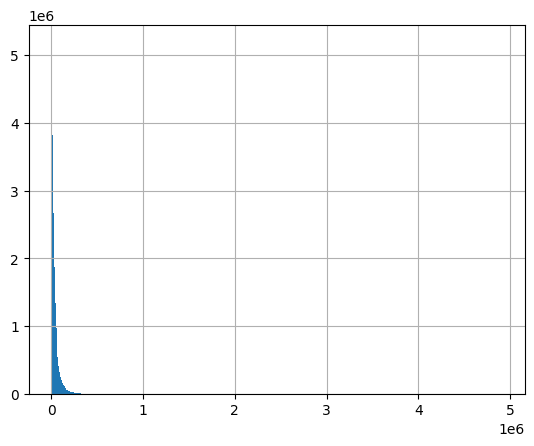

In [65]:
df_w2.income.hist(bins=500)

(0.0, 1000000.0)

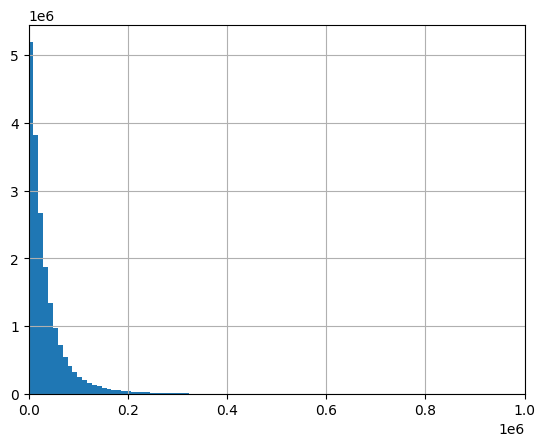

In [54]:
df_w2.income.hist(bins=500)
plt.xlim(0,1e6)

In [76]:
(df_w2.income == 0).sum()

0

Text(0, 0.5, 'number of rows per bin')

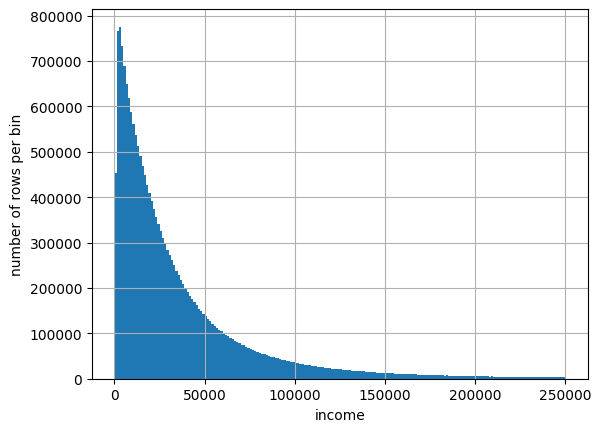

In [78]:
df_w2.query("income < 250_000").income.hist(bins=200)
plt.xlabel("income")
plt.ylabel("number of rows per bin")

In [58]:
%%time
data = df_w2.income
# All shape parameters in the input .csv were near 1, so use s=1 for starting value
# Fix the location at 0 since we don't want a shifted lognormal distribution
params = stats.lognorm.fit(data, 1, floc=0)
params

CPU times: user 104 ms, sys: 32 ms, total: 136 ms
Wall time: 134 ms


(1.2512637, 0.0, 19761.67)

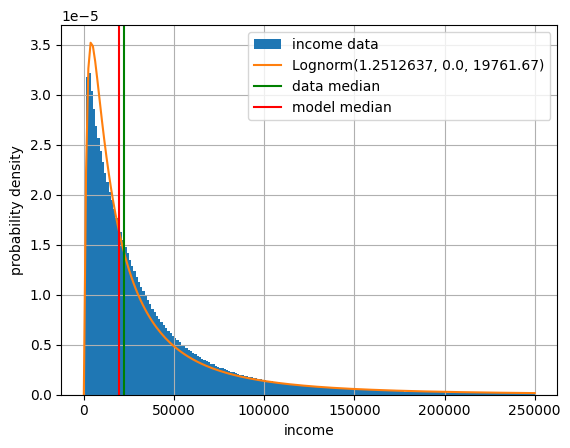

In [77]:
fig, ax = plt.subplots()
df_w2.query("income < 250_000").income.hist(bins=200, density=True, ax=ax, label='income data')

lognorm = stats.lognorm(*params)
x = np.linspace(0, 250_000, 200)
ax.plot(x, lognorm.pdf(x), label=f'Lognorm{params}')

ax.axvline(data.median(), label='data median', c='green')
ax.axvline(lognorm.median(), label='model median', c='red')
ax.set_xlabel("income")
ax.set_ylabel("probability density")
ax.legend()

# Plot distribution of SSNs

Text(0, 0.5, 'number of rows in bin')

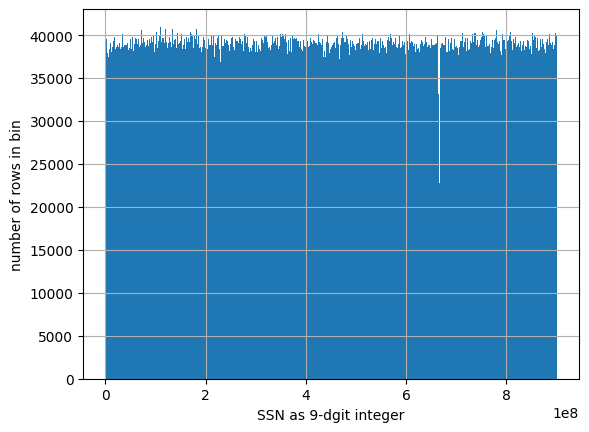

In [81]:
df_w2.ssn.hist(bins=500)
plt.xlabel('SSN as 9-dgit integer')
plt.ylabel('number of rows in bin')

# Check what fraction of people have an employer in a different state from their mailing address

In [88]:
(df_w2.mailing_address_state != df_w2.employer_state).sum() / len(df_w2)

0.9579070421630398

# Check distribution of mailing address states among tax forms

In [91]:
tax_forms_per_state = df_w2.mailing_address_state.value_counts()
tax_forms_per_state

CA    2110036
TX    1667010
FL    1184038
NY    1121358
IL     940550
       ...   
SD      47288
ND      39910
AK      36675
VT      36380
DC      36056
Name: mailing_address_state, Length: 51, dtype: int64

Text(0, 0.5, 'Number of W2/1099 forms')

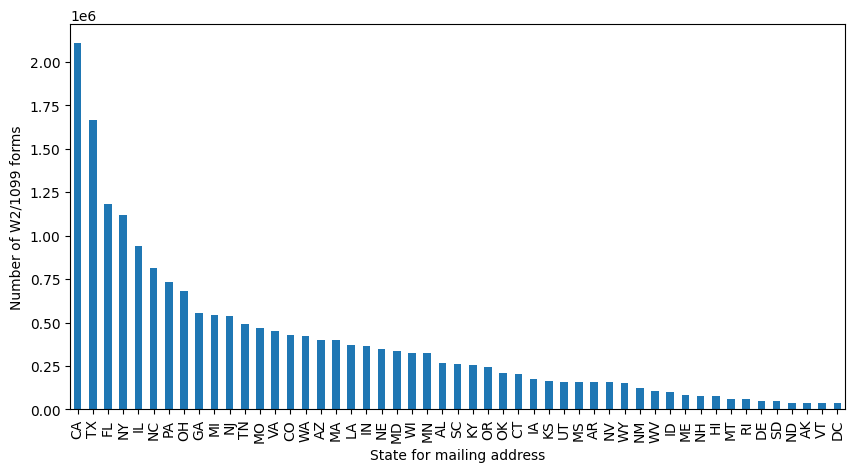

In [93]:
fig, ax = plt.subplots(figsize=(10,5))
tax_forms_per_state.plot.bar(ax=ax)
ax.set_xlabel("State for mailing address")
ax.set_ylabel("Number of W2/1099 forms")

# Plot distribution of employer sizes

In [96]:
%%time
people_per_employer_by_year = df_w2.groupby(["employer_id", "tax_year"])["simulant_id"].nunique()
people_per_employer_by_year

CPU times: user 11.5 s, sys: 1.96 s, total: 13.4 s
Wall time: 13.4 s


employer_id  tax_year
1            2020        17774
             2021        21146
             2022        23169
             2023        25037
             2024        26744
                         ...  
1745105      2025            3
             2026            2
             2027            4
             2028            5
             2029            6
Name: simulant_id, Length: 15004550, dtype: int64

In [104]:
people_per_employer_by_year.loc[:,2025].describe()

count    1.500455e+06
mean     1.363248e+00
std      2.355990e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.876200e+04
Name: simulant_id, dtype: float64

In [106]:
people_per_employer_by_year.describe()

count    1.500455e+07
mean     1.300939e+00
std      2.251662e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.377600e+04
Name: simulant_id, dtype: float64

In [105]:
people_per_employer_by_year.loc[:,people_per_employer_by_year !=0].describe()

count    8.926606e+06
mean     2.186723e+00
std      2.915932e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.377600e+04
Name: simulant_id, dtype: float64

<AxesSubplot: >

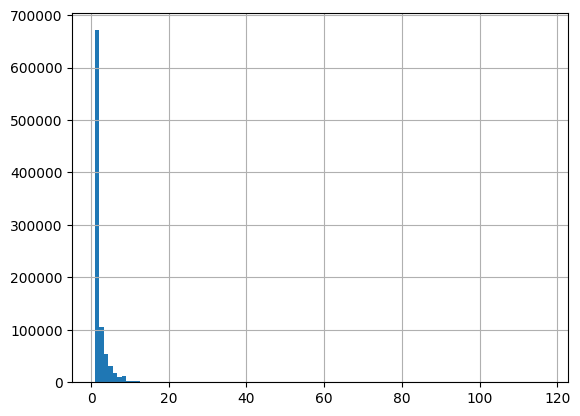

In [110]:
people_per_employer_by_year.reset_index().query("tax_year==2025 and 0<simulant_id < 1000").simulant_id.hist(bins=100)

In [112]:
people_per_employer_by_year.reset_index().query("tax_year==2025 and simulant_id >= 1000").simulant_id.describe()

count        1.0
mean     28762.0
std          NaN
min      28762.0
25%      28762.0
50%      28762.0
75%      28762.0
max      28762.0
Name: simulant_id, dtype: float64

In [115]:
df_w2.loc[df_w2.employer_id==1, ['employer_name', 'employer_state']].value_counts()

employer_name  employer_state
Military       AZ                270350
dtype: int64

In [121]:
4

4

In [123]:
# Get the distribution of sizes of all employers EXCEPT the military
people_per_employer_by_year.loc[2:].describe()

count    1.500454e+07
mean     1.282922e+00
std      1.876056e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.180000e+02
Name: simulant_id, dtype: float64

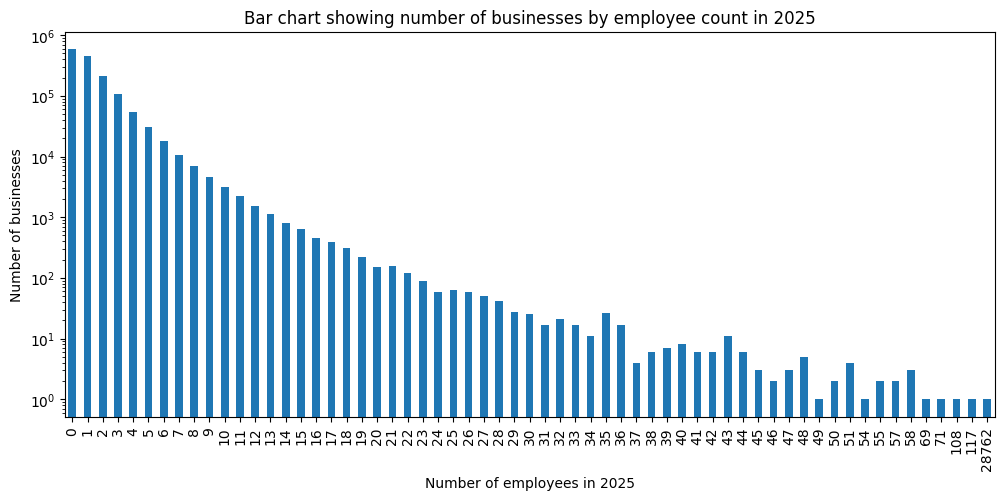

In [153]:
fig, ax = plt.subplots(figsize=(12,5))
year = 2025
people_per_employer_by_year.loc[:,year].value_counts().sort_index().plot.bar(logy=True, ax=ax)
ax.set_xlabel(f"Number of employees in {year}")
ax.set_ylabel("Number of businesses");
ax.set_title(f"Bar chart showing number of businesses by employee count in {year}");

In [159]:
1.3 * 334/2

217.1

In [160]:
1.2 * 334/2

200.4

# Look into employer addresses

In [154]:
df_w2.employer_id

3731  0          1544194
      1           722154
      2           780095
      3           742078
      4          1324410
                  ...   
9971  9769198     362416
      9769199    1448956
      9769200    1359599
      9769201     488026
      9769202    1205672
Name: employer_id, Length: 19520011, dtype: int64

In [156]:
df_w2.loc[
    df_w2.employer_id == 722154,
    ['employer_id', 'employer_name', 'employer_street_name', 'employer_city', 'employer_state', 'tax_year', 'income']
].rename_axis(['seed', 'row']).sort_values(['tax_year', 'seed'])

employer_id                               employer_name  \
seed row                                                                
3731 1             722154  United Pentecostal Church of God Parsonage   
     831966        722154  United Pentecostal Church of God Parsonage   
9971 1657311       722154  United Pentecostal Church of God Parsonage   
3731 1776687       722154  United Pentecostal Church of God Parsonage   
     1956248       722154  United Pentecostal Church of God Parsonage   
     2738611       722154  United Pentecostal Church of God Parsonage   
     2919652       722154  United Pentecostal Church of God Parsonage   
     3713243       722154  United Pentecostal Church of God Parsonage   
     4696744       722154  United Pentecostal Church of God Parsonage   
     5718791       722154  United Pentecostal Church of God Parsonage   
     6717532       722154  United Pentecostal Church of God Parsonage   
     7722405       722154  United Pentecostal Church of God Parsonage   
9971 8130408       722154  United Pentecostal Church of God Parsonage   
     9143867       722154  United Pentecostal Church of God Parsonage   

             employer_street_name employer_city employer_state tax_year  \
seed row                                                                  
3731 1                  n 52nd st     la grange             KY     2020   
     831966             n 52nd st     la grange             KY     2021   
9971 1657311               9th st    louisville             KY     2021   
3731 1776687            n 52nd st     la grange             KY     2022   
     1956248            n 52nd st     la grange             KY     2022   
     2738611        st vardell ln       windsor             SC     2023   
     2919652        st vardell ln       windsor             SC     2023   
     3713243        st vardell ln       windsor             SC     2024   
     4696744        st vardell ln       windsor             SC     2025   
     5718791        st vardell ln       windsor             SC     2026   
     6717532        st vardell ln       windsor             SC     2027   
     7722405        st vardell ln       windsor             SC     2028   
9971 8130408       platanus drive         greer             SC     2028   
     9143867           e kerry ln     kissimmee             FL     2029   

                    income  
seed row                    
3731 1         6509.349121  
     831966    8462.154297  
9971 1657311   9621.737305  
3731 1776687   8462.154297  
     1956248  34598.113281  
     2738611   8462.154297  
     2919652   9885.175781  
     3713243   8462.154297  
     4696744   9113.088867  
     5718791   8462.154297  
     6717532   8462.154297  
     7722405   2603.739746  
9971 8130408  47975.796875  
     9143867  51973.781250

In [158]:
df_w2.loc[
    df_w2.employer_id == 780095,
    ['employer_id', 'employer_name', 'employer_street_name', 'employer_city', 'employer_state', 'tax_year', 'income']
].rename_axis(['seed', 'row']).sort_values(['tax_year', 'seed']).iloc[:40]

employer_id                      employer_name  \
seed row                                                       
3731 2             780095  Dutch Bros Tire Co Op Launderland   
     41207         780095  Dutch Bros Tire Co Op Launderland   
9971 226472        780095  Dutch Bros Tire Co Op Launderland   
     265596        780095  Dutch Bros Tire Co Op Launderland   
     330577        780095  Dutch Bros Tire Co Op Launderland   
3731 831967        780095  Dutch Bros Tire Co Op Launderland   
     878684        780095  Dutch Bros Tire Co Op Launderland   
     1513696       780095  Dutch Bros Tire Co Op Launderland   
9971 1089544       780095  Dutch Bros Tire Co Op Launderland   
     1101134       780095  Dutch Bros Tire Co Op Launderland   
     1121002       780095  Dutch Bros Tire Co Op Launderland   
     1133843       780095  Dutch Bros Tire Co Op Launderland   
     1207989       780095  Dutch Bros Tire Co Op Launderland   
     1464357       780095  Dutch Bros Tire Co Op Launderland   
3731 2113101       780095  Dutch Bros Tire Co Op Launderland   
9971 1998346       780095  Dutch Bros Tire Co Op Launderland   
     2050981       780095  Dutch Bros Tire Co Op Launderland   
     2070916       780095  Dutch Bros Tire Co Op Launderland   
     2083902       780095  Dutch Bros Tire Co Op Launderland   
     2158774       780095  Dutch Bros Tire Co Op Launderland   
     2419076       780095  Dutch Bros Tire Co Op Launderland   
3731 3077798       780095  Dutch Bros Tire Co Op Launderland   
9971 2964002       780095  Dutch Bros Tire Co Op Launderland   
     3016886       780095  Dutch Bros Tire Co Op Launderland   
     3050003       780095  Dutch Bros Tire Co Op Launderland   
     3700632       780095  Dutch Bros Tire Co Op Launderland   
3731 4054063       780095  Dutch Bros Tire Co Op Launderland   
9971 4626661       780095  Dutch Bros Tire Co Op Launderland   
3731 5049350       780095  Dutch Bros Tire Co Op Launderland   
     5279502       780095  Dutch Bros Tire Co Op Launderland   
9971 5642159       780095  Dutch Bros Tire Co Op Launderland   
3731 6061476       780095  Dutch Bros Tire Co Op Launderland   
     6285964       780095  Dutch Bros Tire Co Op Launderland   
     6388427       780095  Dutch Bros Tire Co Op Launderland   
     6536572       780095  Dutch Bros Tire Co Op Launderland   
9971 6239952       780095  Dutch Bros Tire Co Op Launderland   
     6640537       780095  Dutch Bros Tire Co Op Launderland   
3731 6876833       780095  Dutch Bros Tire Co Op Launderland   
     7284388       780095  Dutch Bros Tire Co Op Launderland   
     7384187       780095  Dutch Bros Tire Co Op Launderland   

             employer_street_name employer_city employer_state tax_year  \
seed row                                                                  
3731 2                skyview ter        toledo             OH     2020   
     41207            skyview ter        toledo             OH     2020   
9971 226472      blue hill avenue        euclid             OH     2020   
     265596      blue hill avenue        euclid             OH     2020   
     330577      blue hill avenue        euclid             OH     2020   
3731 831967           skyview ter        toledo             OH     2021   
     878684           skyview ter        toledo             OH     2021   
     1513696          skyview ter        toledo             OH     2021   
9971 1089544     blue hill avenue        euclid             OH     2021   
     1101134     blue hill avenue        euclid             OH     2021   
     1121002     blue hill avenue        euclid             OH     2021   
     1133843     blue hill avenue        euclid             OH     2021   
     1207989     blue hill avenue        euclid             OH     2021   
     1464357     blue hill avenue        euclid             OH     2021   
3731 2113101          skyview ter        toledo             OH     2022   
9971 1998346     blue hill avenue        euclid   